<h1><center>Tutorial for implementing Sapcell on ALS dataset</center></h1>

This tutorial provids the step-by-step implementation of using Sapcell to find cell types in one spatial transcriptomics tissue slide in ALS dataset and classification of ALS disease stages among all samples in ALS dataset.

## Make your own configurations

Specify input/output path and model parameters in `config.py`

In [1]:
# path config
META_PATH = '../dataset/metadata/mouse_sample_names_sra.tsv'
IMG_PATH = '../dataset/image/'
CM_PATH = '../dataset/cm/'
ATM_PATH = None
TILE_PATH = '../dataset/tile/'
DATASET_PATH = '../dataset/'
TEMPLATE_IMG = '../dataset/image/CN94_D2_HE.jpg'

# image config
SIZE = 299, 299
N_CHANNEL = 3

NORM_METHOD = 'vahadane'
# count matrix config

THRESHOLD_GENE = 0.01
THRESHOLD_SPOT = 0.01
MIN_EXP = 1

# metadata config
SAMPLE_COLUMN = 'sample_name'
LABEL_COLUMN = 'age'
CONDITION_COLUMN = 'breed'
CONDITION = 'B6SJLSOD1-G93A'
ADDITIONAL_COLUMN = 2 if CONDITION_COLUMN else 1

# reproducibility
seed = 37

# color_map 
color_map = ['#ff8aff', '#6fc23f', '#af63ff', '#eaed00', '#f02449', '#00dbeb', '#d19158', '#9eaada', '#89af7c', '#514036']

# classification model config
n_classes = 4
batch_size = 32
epochs = 10
train_ratio = 0.7

### 1. Image Preprocessing

#### 1.1 Run in Command Line 

In [2]:
%%bash
python ../SpaCell/image_normalization.py

generate tile of sample CN51_C2_2 at spot 3.942x25.915
generate tile of sample CN51_C2_2 at spot 2.977x25.938
generate tile of sample CN51_C2_2 at spot 1.996x25.956
generate tile of sample CN51_C2_2 at spot 4.975x26.895
generate tile of sample CN51_C2_2 at spot 3.947x26.901
generate tile of sample CN51_C2_2 at spot 2.987x26.921
generate tile of sample CN51_C2_2 at spot 2.004x26.954
generate tile of sample CN51_C2_2 at spot 3.973x27.906
generate tile of sample CN51_C2_2 at spot 3.01x27.933
generate tile of sample CN51_C2_2 at spot 4.978x27.919
generate tile of sample CN51_C2_2 at spot 2.015x27.936
generate tile of sample CN51_C2_2 at spot 4.976x28.887
generate tile of sample CN51_C2_2 at spot 5.933x28.889
generate tile of sample CN51_C2_2 at spot 3.981x28.894
generate tile of sample CN51_C2_2 at spot 2.974x28.927
generate tile of sample CN51_C2_2 at spot 2.026x28.94
generate tile of sample CN51_C2_2 at spot 4.981x29.881
generate tile of sample CN51_C2_2 at spot 5.957x29.916
generate til

#### 1.2 Detailed run in Python (equivalent to the one liner Spacell code above)

In [3]:
import os
from os import path
import numpy as np
import pandas as pd
import shutil
import glob
import random
import staintools
from staintools import stain_normalizer, LuminosityStandardizer
from staintools import ReinhardColorNormalizer
# from multiprocessing import Pool
import PIL
from PIL import Image, ImageDraw

In [4]:
Image.MAX_IMAGE_PIXELS = None

In [5]:
def offset_img(img, r_offset, g_offset, b_offset):
    """
    Add colour offset for a Pillow image object.
    
    :param img: Pillow image object
    :param r_offset(float): red colour offset pixel value
    :param g_offset(float): green colour offset pixel value
    :param b_offset(float): blue colour offset pixel value
    :return: new Pillow image object with colour offset
    """
    new_img = img.copy()
    pixels = new_img.load()
    for i in range(img.size[0]):   #For every column
        for j in range(img.size[1]):    #For every row
            r, g, b = pixels[i,j]
            new_r, new_g, new_b = r+r_offset, g+g_offset, b+b_offset
            pixels[i,j] = int(new_r), int(new_g), int(new_b)
    return new_img 


def scale_rgb(img, r_scale, g_scale, b_scale):
    """
    Scale colour channels for a Pillow image object.
    
    :param img: Pillow image object
    :param r_scale(float): red colour scale factor
    :param g_scale(float): green colour scale factor
    :param b_scale(float): blue colour scale factor
    :return: scaled Pillow image object
    """
    source = img.split()
    R, G, B = 0, 1, 2
    red = source[R].point(lambda i:i*r_scale)
    green = source[G].point(lambda i:i*g_scale)
    blue = source[B].point(lambda i:i*b_scale)
    return Image.merge('RGB', [red, green, blue])


def remove_colour_cast(img):
    """
    Select 99th percentile pixels values for each channel for a Pillow image object.
    
    :param img: Pillow image object
    :return: Pillow image object without colour cast
    """
    img = img.convert('RGB')
    img_array = np.array(img)
    #Calculate 99th percentile pixels values for each channel
    rp = np.percentile(img_array[:,:,0].ravel(), q = 99)
    gp = np.percentile(img_array[:,:,1].ravel(), q = 99)
    bp = np.percentile(img_array[:,:,2].ravel(), q = 99)
    #scale image based on percentile values
    return scale_rgb(img, 255/rp, 255/gp, 255/bp)


def tile(img, spots_center_gen, out_dir, atm):
     """
    Tile whole slide image based on spot coords and affine transformation matrix. \
    One tile contains one spot. 
    
    :param img: Pillow image object
    :param spots_center_gen (str): spots coords (XxY)
    :param out_dir: output path
    :param atm (list): affine transformation matrix. None, if not provided.
    :return: None
    """
    sample = os.path.split(out_dir)[-1]
    for x_coord, y_coord in spots_center_gen:
        if atm:
            x_pixel = float(x_coord) * float(atm[0]) + float(atm[6])
            y_pixel = float(y_coord) * float(atm[4]) + float(atm[7])
            x_0 = x_pixel - float(atm[0]) * 0.8 / 2
            y_0 = y_pixel - float(atm[4]) * 0.8 / 2
            x_1 = x_pixel + float(atm[0]) * 0.8 / 2
            y_1 = y_pixel + float(atm[4]) * 0.8 / 2
        else:
            unit_x = float(img.size[0]) / 32
            unit_y = float(img.size[0]) / 34
            x_pixel = float(x_coord) * unit_x
            y_pixel = float(y_coord) * unit_y
            x_0 = x_pixel - unit_x * 0.8 / 2
            y_0 = y_pixel - unit_y * 0.8 / 2
            x_1 = x_pixel + unit_x * 0.8 / 2
            y_1 = y_pixel + unit_y * 0.8 / 2
        tile = img.crop((x_0, y_0, x_1, y_1))
        tile.thumbnail(SIZE, Image.ANTIALIAS)
        tile_name = str(sample) + '-' + str(x_coord) + '-' + str(y_coord)
        print("generate tile of sample {} at spot {}x{}".format(str(sample), str(x_coord), str(y_coord)))
        tile.save(os.path.join(out_dir, tile_name + '.jpeg'), 'JPEG')


def mkdirs(dirs):
    if not os.path.exists(dirs):
        os.makedirs(dirs)

        
def spot_gen(cm):
     """
    Generate spot coords
    
    :param cm: pandas dataframe, spot coords (XxY) as column name. 
    :yield: tuple(X, Y) 
    """
    for spot in [x.split('x') for x in cm]:
        x_point = spot[0]
        y_point = spot[1]
        yield x_point, y_point

        
def img_cm_gen(img_path, cm_path, sample_name):
    """
    Using sample name to pair image and count matrix
    
    :param img_path (list): list of image path
    :param cm_path (list): list of count matrix path
    :param sample_name (list): list of sample name 
    :yield: paired (sample name, image path, count matrix path)
    """
    for sample in sample_name:
        for cm_root, _, cm_files in os.walk(cm_path):
            for cm_file in cm_files:
                if cm_file.endswith(".txt") and cm_file.startswith(sample):
                    pattern = "_".join(sample.split("_")[0:2])
                    for img_root, _, img_files in os.walk(img_path):
                        for img_file in img_files:
                            if img_file.endswith(".jpg") and img_file.startswith(pattern):
                                assert "_".join(img_file.split("_")[0:2]) == "_".join(cm_file.split("_")[0:2])
                                yield (sample, os.path.join(img_path, img_file), os.path.join(cm_path, cm_file))

Load template image and create stain normalizer based on template image using staintools package

In [6]:
template = Image.open(TEMPLATE_IMG)
normalizer = staintools.StainNormalizer(method=NORM_METHOD)
template_std = LuminosityStandardizer.standardize(np.array(template))
normalizer.fit(template_std)

Load metadata and find sample

In [7]:
meta_data = pd.read_csv(META_PATH, header=0, sep='\t')
sample_name = list(meta_data.loc[:, SAMPLE_COLUMN])

Normalize and tile whole slide images, each tile will contain one spot.

In [8]:
for sample, img_path, cm_path in img_cm_gen(IMG_PATH, CM_PATH, sample_name):
    if ATM_PATH:
        atm_file = open(ATM_PATH, "r")
        atm = atm_file.read().split(" ")
    else:
        atm = None
    img = Image.open(img_path)
    
    # image normalization
    img_uncast = remove_colour_cast(img)
    img_std = LuminosityStandardizer.standardize(np.array(img_uncast))
    transformed = normalizer.transform(img_std)
    img = Image.fromarray(transformed)
    
    # find spots
    cm = pd.read_csv(cm_path, header=0, sep='\t', index_col=0)
    cm = cm.transpose()
    spots_center_gen = spot_gen(cm)
    tile_out = os.path.join(TILE_PATH, sample)
    mkdirs(tile_out)
    
    # tiling
    tile(img, spots_center_gen, tile_out, atm)

['3.942', '25.915']
generate tile of sample CN51_C2_2 at spot 3.942x25.915
['2.977', '25.938']
generate tile of sample CN51_C2_2 at spot 2.977x25.938
['1.996', '25.956']
generate tile of sample CN51_C2_2 at spot 1.996x25.956
['4.975', '26.895']
generate tile of sample CN51_C2_2 at spot 4.975x26.895
['3.947', '26.901']
generate tile of sample CN51_C2_2 at spot 3.947x26.901
['2.987', '26.921']
generate tile of sample CN51_C2_2 at spot 2.987x26.921
['2.004', '26.954']
generate tile of sample CN51_C2_2 at spot 2.004x26.954
['3.973', '27.906']
generate tile of sample CN51_C2_2 at spot 3.973x27.906
['3.01', '27.933']
generate tile of sample CN51_C2_2 at spot 3.01x27.933
['4.978', '27.919']
generate tile of sample CN51_C2_2 at spot 4.978x27.919
['2.015', '27.936']
generate tile of sample CN51_C2_2 at spot 2.015x27.936
['4.976', '28.887']
generate tile of sample CN51_C2_2 at spot 4.976x28.887
['5.933', '28.889']
generate tile of sample CN51_C2_2 at spot 5.933x28.889
['3.981', '28.894']
generat

['21.93', '1.92']
generate tile of sample CN94_D2 at spot 21.93x1.92
['20.92', '1.94']
generate tile of sample CN94_D2 at spot 20.92x1.94
['20.02', '1.98']
generate tile of sample CN94_D2 at spot 20.02x1.98
['25.94', '1.97']
generate tile of sample CN94_D2 at spot 25.94x1.97
['26.96', '1.97']
generate tile of sample CN94_D2 at spot 26.96x1.97
['18.92', '1.99']
generate tile of sample CN94_D2 at spot 18.92x1.99
['22.98', '2.01']
generate tile of sample CN94_D2 at spot 22.98x2.01
['24.96', '1.99']
generate tile of sample CN94_D2 at spot 24.96x1.99
['17.94', '2.02']
generate tile of sample CN94_D2 at spot 17.94x2.02
['24.01', '2.03']
generate tile of sample CN94_D2 at spot 24.01x2.03
['21.94', '2.95']
generate tile of sample CN94_D2 at spot 21.94x2.95
['20.93', '2.96']
generate tile of sample CN94_D2 at spot 20.93x2.96
['26.95', '3']
generate tile of sample CN94_D2 at spot 26.95x3
['20.01', '3']
generate tile of sample CN94_D2 at spot 20.01x3
['25.94', '2.99']
generate tile of sample CN94

['21.91', '22.87']
generate tile of sample CN94_D2 at spot 21.91x22.87
['20.91', '22.87']
generate tile of sample CN94_D2 at spot 20.91x22.87
['10.92', '22.89']
generate tile of sample CN94_D2 at spot 10.92x22.89
['26.96', '22.91']
generate tile of sample CN94_D2 at spot 26.96x22.91
['9.92', '22.91']
generate tile of sample CN94_D2 at spot 9.92x22.91
['27.92', '22.9']
generate tile of sample CN94_D2 at spot 27.92x22.9
['20.02', '22.91']
generate tile of sample CN94_D2 at spot 20.02x22.91
['5.91', '22.92']
generate tile of sample CN94_D2 at spot 5.91x22.92
['2.94', '22.93']
generate tile of sample CN94_D2 at spot 2.94x22.93
['23.02', '22.94']
generate tile of sample CN94_D2 at spot 23.02x22.94
['25.95', '22.92']
generate tile of sample CN94_D2 at spot 25.95x22.92
['28.97', '22.91']
generate tile of sample CN94_D2 at spot 28.97x22.91
['7.93', '22.93']
generate tile of sample CN94_D2 at spot 7.93x22.93
['24.97', '22.92']
generate tile of sample CN94_D2 at spot 24.97x22.92
['9.03', '22.93'

['2.95', '27.98']
generate tile of sample CN94_D2 at spot 2.95x27.98
['4.96', '27.99']
generate tile of sample CN94_D2 at spot 4.96x27.99
['2', '28']
generate tile of sample CN94_D2 at spot 2x28
['3.01', '28.97']
generate tile of sample CN94_D2 at spot 3.01x28.97
['5.92', '28.95']
generate tile of sample CN94_D2 at spot 5.92x28.95
['6.94', '28.97']
generate tile of sample CN94_D2 at spot 6.94x28.97
['3.95', '28.97']
generate tile of sample CN94_D2 at spot 3.95x28.97
['4.95', '28.99']
generate tile of sample CN94_D2 at spot 4.95x28.99
['2.01', '29.01']
generate tile of sample CN94_D2 at spot 2.01x29.01
['5.92', '29.92']
generate tile of sample CN94_D2 at spot 5.92x29.92
['4.94', '29.98']
generate tile of sample CN94_D2 at spot 4.94x29.98


### 2. Count Matrix Preprocessing

#### 2.1 Run in Command Line 

In [9]:
%%bash
python ../SpaCell/count_matrix_normalization.py

Number of expressed genes a spot must have to be kept (0.01% of total expressed genes) 88.0
Dropped 5 spots
Removing genes that are expressed in less than 4 spots with a count of at least 1
Dropped 4365 genes


#### 2.2 Detailed run in Python (equivalent to the one liner Spacell code above)

In [10]:
import pandas as pd
import os
import glob
import numpy as np

In [48]:
def add_label(dataframe, label, meta):
    """
    Add label for each sample in count matrix for classfication use.
    
    :param dataframe : pandas data frame object
    :param label (list): list of labels
    :return: new dataframe with label as last column
    """
    label_list = []
    for spot in dataframe.index.values:
        sample_id = '_'.join(spot.split('_')[:-1])
        spot_label = meta.loc[sample_id, label]
        label_list.append(spot_label)
    dataframe[label] = label_list
    return dataframe

Merge all count matries to one, replace missing values with 0

In [49]:
meta_data = pd.read_csv(META_PATH, header=0, sep='\t', index_col=0)
sample_name = list(meta_data.index)
total_counts = pd.DataFrame()
for file in glob.glob(CM_PATH+'*.txt'):
    sample_n = '_'.join(os.path.basename(file).split("_")[0:-4])
    if sample_n in sample_name:
        cm = pd.read_csv(file, header = 0,sep='\t', index_col=0)  # column:genes row:spots
        # reindex
        new_spots = ["{0}_{1}".format(sample_n, spot) for spot in cm.index]
        cm.index = new_spots
        total_counts = total_counts.append(cm, sort=False)

# replace missing values with 0
total_counts.replace([np.inf, -np.inf], np.nan)
total_counts.fillna(0.0, inplace=True)

In [50]:
num_spots = len(total_counts.index)
num_genes = len(total_counts.columns)
print("Number of total spots: {}".format(num_spots))
print("Number of total genes: {}".format(num_genes))

Number of total spots: 422
Number of total genes: 16072


Remove low quality spots

In [51]:
min_genes_spot = round((total_counts != 0).sum(axis=1).quantile(THRESHOLD_SPOT))
print("Number of expressed genes a spot must have to be kept ({}% of total expressed genes) {}".format(THRESHOLD_SPOT, min_genes_spot))
total_counts = total_counts[(total_counts != 0).sum(axis=1) >= min_genes_spot]
print("Dropped {} spots".format(num_spots - len(total_counts.index)))

Number of expressed genes a spot must have to be kept (0.01% of total expressed genes) 88.0
Dropped 5 spots


Remove low quality genes

In [52]:
# Spots are columns and genes are rows
total_counts = total_counts.transpose()

min_spots_gene = round(len(total_counts.columns) * THRESHOLD_GENE)
print("Removing genes that are expressed in less than {} spots with a count of at least {}".format(min_spots_gene, MIN_EXP))
total_counts = total_counts[(total_counts >= MIN_EXP).sum(axis=1) >= min_spots_gene]
print("Dropped {} genes".format(num_genes - len(total_counts.index)))

Removing genes that are expressed in less than 4 spots with a count of at least 1
Dropped 4365 genes


Count matrix normalized by total counts per spot

In [53]:
# Spots are rows and genes are columns
total_counts = total_counts.transpose()

row_sum = total_counts.sum(axis=1)
normal_total_counts = total_counts.div(row_sum, axis=0)

Add label and save data

In [54]:
normal_total_counts = add_label(normal_total_counts, LABEL_COLUMN , meta_data)
if CONDITION_COLUMN:
    normal_total_counts = add_label(normal_total_counts, CONDITION_COLUMN, meta_data)
normal_total_counts.to_csv(os.path.join(DATASET_PATH,'cm_norm.tsv'), sep='\t')

### 3. Generate Paired Image and Gene Count Training Dataset

#### 3.1 Run in Command Line 

In [56]:
%%bash
python ../SpaCell/dataset_management.py

Using TensorFlow backend.


#### 3.2 Detailed run in Python (equivalent to the one liner Spacell code above)

In [57]:
import glob
import keras
import numpy as np
import pandas as pd
import os
import time 
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import xception
from keras.utils import to_categorical

Load normalized count matrix

In [58]:
cm = pd.read_csv(os.path.join(DATASET_PATH, 'cm_norm.tsv'), header=0, sep='\t', index_col=0)

Check if label has condition, subset count matrix with condition

In [59]:
if CONDITION_COLUMN:
    cm_ = cm[cm[CONDITION_COLUMN] == CONDITION]
    cm = cm_

Pairing each spot with its corresponding gene counts

In [61]:
col_cm = list(cm.index)
img_files = glob.glob(TILE_PATH+'/*/*.jpeg')
sorted_img = []
sorted_cm = []
for img in img_files:
    id_img = os.path.splitext(os.path.basename(img))[0].replace("-", "_")
    for c in col_cm:
        id_c = c.replace("x", "_")
        if id_img == id_c:
            sorted_img.append(img)
            sorted_cm.append(c)

Generate dataset index file

In [62]:
cm = cm.reindex(sorted_cm)
df = pd.DataFrame(data={'img':sorted_img,
                        'cm':sorted_cm, 
                        'label':cm[LABEL_COLUMN]})
df.to_csv(os.path.join(DATASET_PATH, 'dataset_age.tsv'), sep='\t')
cm.to_csv(os.path.join(DATASET_PATH, "cm_age.tsv"), sep='\t')

### 4. Classification for ALS Disease Stages

#### 4.1 Run in Command Line 

In [136]:
%%bash
python ../SpaCell/spacell_classification.py

Epoch 1/10
9/9 [==============================] - 60s 7s/step - loss: 0.5472 - acc: 0.7431
Epoch 2/10
9/9 [==============================] - 37s 4s/step - loss: 0.1524 - acc: 0.9271
Epoch 3/10
9/9 [==============================] - 38s 4s/step - loss: 0.0916 - acc: 0.9410
Epoch 4/10
9/9 [==============================] - 39s 4s/step - loss: 0.0417 - acc: 0.9792
Epoch 5/10
9/9 [==============================] - 38s 4s/step - loss: 0.0828 - acc: 0.9931
Epoch 6/10
9/9 [==============================] - 38s 4s/step - loss: 0.3402 - acc: 0.9618
Epoch 7/10
9/9 [==============================] - 39s 4s/step - loss: 0.2010 - acc: 0.9549
Epoch 8/10
9/9 [==============================] - 38s 4s/step - loss: 0.1864 - acc: 0.9618
Epoch 9/10
9/9 [==============================] - 39s 4s/step - loss: 0.0821 - acc: 0.9792
Epoch 10/10
126/126 [==============================] - 14s 112ms/step
[[1.         0.        ]
 [0.17777778 0.82222222]]


Using TensorFlow backend.
W0827 12:40:43.076764 47467222617792 deprecation_wrapper.py:119] From /90days/uqxtan9/.conda/envs/st_dl/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0827 12:40:43.091698 47467222617792 deprecation_wrapper.py:119] From /90days/uqxtan9/.conda/envs/st_dl/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0827 12:40:43.108878 47467222617792 deprecation_wrapper.py:119] From /90days/uqxtan9/.conda/envs/st_dl/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0827 12:40:43.109000 47467222617792 deprecation_wrapper.py:119] From /90days/uqxtan9/.conda/envs/st_dl/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_de

#### 4.2 Detailed run in Python (equivalent to the one liner Spacell code above)

In [82]:
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.layers import Dense, GlobalAveragePooling2D, Input, concatenate, Dropout, Lambda
from keras.applications import xception
from keras.utils import multi_gpu_model
from keras.applications.xception import Xception
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.models import Model, Sequential

In [73]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, df, cm_df, le, batch_size=32, dim=(299,299), n_channels=3,
                 cm_len = None, n_classes=n_classes, shuffle=True, is_train=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.list_IDs = cm_df.index
        self.n_channels = n_channels
        self.cm_len = cm_len
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.cm_df = cm_df
        self.le = le
        self.is_train = is_train
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X_img, X_cm, y = self.__data_generation(list_IDs_temp)
        if self.is_train:
            return [X_img, X_cm], y
        else: 
            return [X_img, X_cm]

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X_img = np.empty((self.batch_size, *self.dim, self.n_channels))
        X_cm = np.empty((self.batch_size, self.cm_len))
        y = np.empty((self.batch_size, self.n_classes), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store img
            X_img[i,] = self._load_img(ID)
            
            # Store cm
            X_cm[i,] = self._load_cm(ID)
            # Store class
            y[i,] = self._load_label(ID)

        return X_img, X_cm, y
    
    def _load_img(self, img_temp):
        img_path = self.df.loc[img_temp, 'img']
        X_img = image.load_img(img_path, target_size=self.dim)
        X_img = image.img_to_array(X_img)
        X_img = np.expand_dims(X_img, axis=0)
        X_img = xception.preprocess_input(X_img)
        return X_img
    
    def _load_cm(self, cm_temp):
        spot = self.df.loc[cm_temp, 'cm']
        X_cm = self.cm_df.ix[spot, :-ADDITIONAL_COLUMN].values
        return X_cm
    
    def _load_label(self, lable_temp):
        spot = self.df.loc[lable_temp, 'cm']
        y = self.cm_df.ix[spot, [-ADDITIONAL_COLUMN]].values
        y = self.le.transform(y)
        return to_categorical(y, num_classes=self.n_classes)
    
    def get_classes(self):
        if not self.is_train:
            y = self.cm_df.iloc[:, [-ADDITIONAL_COLUMN]].values
            y = self.le.transform(y)
            return y

In [95]:
def st_comb_nn(tile_shape, cm_shape, output_shape):
    """
    Neural network model for classification. 
    
    :param tile_shape: dimension of tile image
    :param cm_shape: dimension of count matrix
    :param output_shape: number of output classes
    :return: compiled classification model
    """
    #### xception base for tile
    tile_input = Input(shape=tile_shape, name = "tile_input")
    xception_base = Xception(input_tensor=tile_input, weights='imagenet', include_top=False)
    x_tile = xception_base.output
    x_tile = GlobalAveragePooling2D()(x_tile)
    x_tile = Dense(512, activation='relu', name="tile_fc")(x_tile)
    #### NN for count matrix
    cm_input = Input(shape=cm_shape, name="count_matrix_input")
    x_cm = Dense(512, activation='relu', name="cm_fc")(cm_input)
    #### merge
    merge = concatenate([x_tile, x_cm], name="merge_tile_cm")
    merge = Dense(512, activation='relu', name="merge_fc_1")(merge)
    merge = Dense(128, activation='relu', name="merge_fc_2")(merge)
    preds = Dense(output_shape, activation='softmax')(merge)
    ##### compile model
    model = Model(inputs=[tile_input, cm_input], outputs=preds)
    try:
        parallel_model = multi_gpu_model(model, gpus=4, cpu_merge=False)
    except:
        parallel_model = model
    parallel_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return parallel_model, model


def model_eval(y_pred, y_true, class_list):
    """
    Generate ROC plot and confusion matrix for evaluate model. 
    
    :param y_pred: predicted score for each label
    :param y_true: true label
    :param class_list: list of classes
    :return: None 
    """
    y_true_onehot = np.zeros((len(y_true), len(class_list)))
    y_true_onehot[np.arange(len(y_true)), y_true] = 1
    y_pred_int = np.argmax(y_pred, axis=1)
    confusion_matrix_age = confusion_matrix(y_true, y_pred_int)
    plt.figure(figsize = (4,4), dpi = 180)
    color = ['blue', 'green', 'red', 'cyan']
    for i in range(len(class_list)):
        fpr, tpr, thresholds = roc_curve(y_true_onehot[:,i], y_pred[:,i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=color[i], lw=2, label='ROC %s curve (area = %0.2f)' % (class_list[i], roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('roc_auc')
    plt.legend(loc="lower right")
    plt.savefig('./age_roc_combine.pdf')
    plt.tight_layout()
    cm_plot = plot_confusion_matrix(confusion_matrix_age, classes = class_list)


def plot_confusion_matrix(cm, classes=None):
    """
    Generate confusion matrix for evaluate model. 
    
    :param cm: confusion matrix
    :param class: list of classes
    :return: confusion matrix plot 
    """
    #Normalise Confusion Matrix by dividing each value by the sum of that row
    cm = cm.astype('float')/cm.sum(axis = 1)[:, np.newaxis]
    print(cm)
    #Make DataFrame from Confusion Matrix and classes
    cm_df = pd.DataFrame(cm, index = classes, columns = classes)
    #Display Confusion Matrix 
    plt.figure(figsize = (4,4), dpi = 180)
    cm_plot = sns.heatmap(cm_df, vmin = 0, vmax = 1, annot = True, fmt = '.2f', cmap = 'Blues', square = True)
    plt.title('Confusion Matrix', fontsize = 12)
    #Display axes labels
    plt.ylabel('True label', fontsize = 12)
    plt.xlabel('Predicted label', fontsize = 12)
    plt.savefig('./age_confusion_matrix_combine.pdf')
    plt.tight_layout()
    return cm_plot

Load dataset index file and count matrix 

In [75]:
df = pd.read_csv(os.path.join(DATASET_PATH, "dataset_age.tsv"), header=0, sep='\t', index_col=0)
sorted_cm = pd.read_csv(os.path.join(DATASET_PATH, "cm_age.tsv"), header=0, sep='\t', index_col=0)

Encode lable to number 

In [76]:
label_encoder = LabelEncoder()
class_list = list(set(sorted_cm.loc[:, LABEL_COLUMN]))
label_encoder.fit(class_list)

LabelEncoder()

Split train and test dataset

In [77]:
train_index, test_index = train_test_split(sorted_cm.index, train_size=train_ratio, shuffle=True)
train_cm = sorted_cm.loc[train_index,:]
test_cm = sorted_cm.loc[test_index,:]

Prepare dataset for training and testing  

In [78]:
cm_shape = train_cm.shape[1]-ADDITIONAL_COLUMN
train_gen = DataGenerator(df=df, 
                          cm_df=train_cm, 
                          le=label_encoder, 
                          cm_len=cm_shape, 
                          batch_size=batch_size)
test_gen = DataGenerator(df=df, 
                         cm_df=test_cm, 
                         le=label_encoder, 
                         shuffle=False, 
                         is_train=False, 
                         batch_size=1, 
                         cm_len=cm_shape)

Compile model and training model

In [83]:
parallel_model_combine, model_ = st_comb_nn((SIZE[0], SIZE[1], N_CHANNEL), (cm_shape,), n_classes)
parallel_model_combine.fit_generator(generator=train_gen,
                                     steps_per_epoch=len(train_gen),
                                     epochs=epochs)

W0827 11:29:10.340057 47578494291648 deprecation_wrapper.py:119] From /90days/uqxtan9/.conda/envs/st_dl/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0827 11:29:10.475870 47578494291648 deprecation.py:323] From /90days/uqxtan9/.conda/envs/st_dl/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10


/90days/uqxtan9/.conda/envs/st_dl/lib/python3.7/site-packages/ipykernel_launcher.py:73: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/90days/uqxtan9/.conda/envs/st_dl/lib/python3.7/site-packages/ipykernel_launcher.py:78: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


9/9 [==============================] - 79s 9s/step - loss: 0.4701 - acc: 0.8160
Epoch 2/10
9/9 [==============================] - 56s 6s/step - loss: 0.1158 - acc: 0.9375
Epoch 3/10
9/9 [==============================] - 56s 6s/step - loss: 0.1050 - acc: 0.9583
Epoch 4/10
9/9 [==============================] - 54s 6s/step - loss: 0.1521 - acc: 0.9514
Epoch 5/10
9/9 [==============================] - 53s 6s/step - loss: 0.0732 - acc: 0.9618
Epoch 6/10
9/9 [==============================] - 54s 6s/step - loss: 0.0681 - acc: 0.9757
Epoch 7/10
9/9 [==============================] - 56s 6s/step - loss: 0.0550 - acc: 0.9826
Epoch 8/10
9/9 [==============================] - 56s 6s/step - loss: 0.0329 - acc: 0.9896
Epoch 9/10
9/9 [==============================] - 55s 6s/step - loss: 0.0773 - acc: 0.9757
Epoch 10/10
9/9 [==============================] - 55s 6s/step - loss: 0.0789 - acc: 0.9896


Predict label for test dataset and evaluate model performance

/90days/uqxtan9/.conda/envs/st_dl/lib/python3.7/site-packages/ipykernel_launcher.py:73: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/90days/uqxtan9/.conda/envs/st_dl/lib/python3.7/site-packages/ipykernel_launcher.py:78: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


126/126 [==============================] - 23s 186ms/step


/90days/uqxtan9/.conda/envs/st_dl/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


[[0.90361446 0.09638554]
 [0.09302326 0.90697674]]


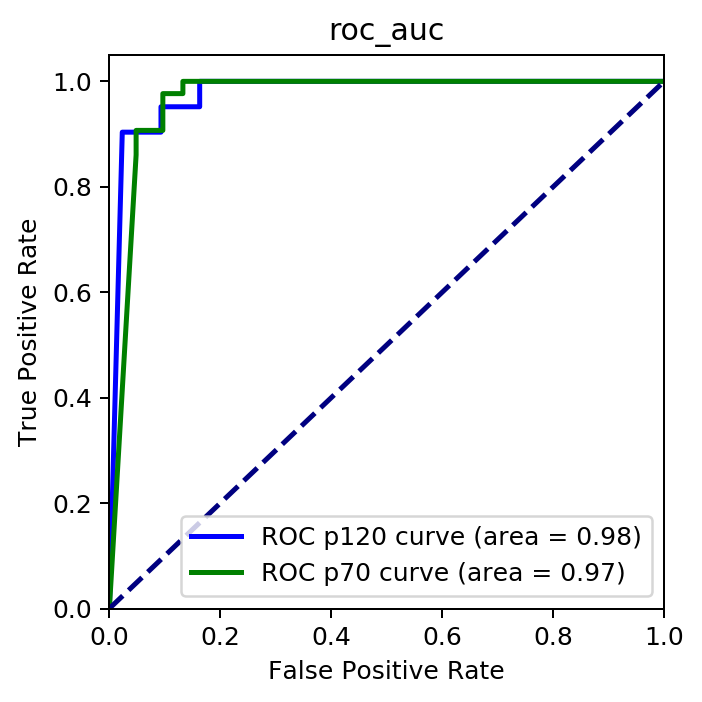

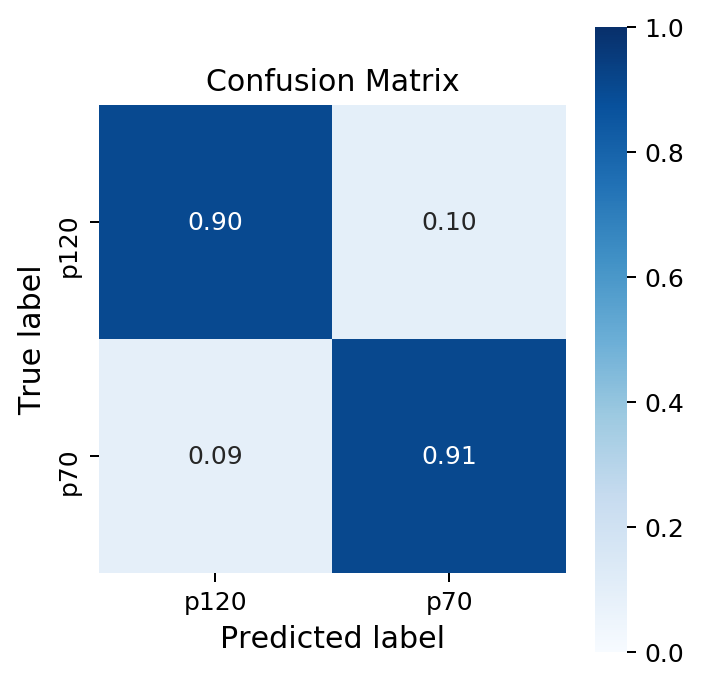

In [96]:
#Note: here, for an example run, we only be using 4 images in the model (in the manuscript we used >200 images and had the Supplementary Figure 2)
y_pred = parallel_model_combine.predict_generator(generator=test_gen, verbose=1)
y_true = sorted_cm.ix[test_index,-ADDITIONAL_COLUMN].values
y_true = label_encoder.transform(y_true)
model_eval(y_pred, y_true, class_list=class_list)

### 5. Clustering for Finding Grey Matter and White Matter

#### 5.1 Run in Command Line 

In [134]:
%%bash
python ../SpaCell/spacell_clustering.py -i ../dataset/image/CN51_C2_HE.jpg \
                                        -l ../dataset/tile/CN51_C2_2 \
                                        -c ../dataset/cm/CN51_C2_2_stdata_aligned_counts_IDs.txt \
                                        -e 10 \
                                        -k 2 \
                                        -o ../results/

generate features for 1th tile
generate features for 2th tile
generate features for 3th tile
generate features for 4th tile
generate features for 5th tile
generate features for 6th tile
generate features for 7th tile
generate features for 8th tile
generate features for 9th tile
generate features for 10th tile
generate features for 11th tile
generate features for 12th tile
generate features for 13th tile
generate features for 14th tile
generate features for 15th tile
generate features for 16th tile
generate features for 17th tile
generate features for 18th tile
generate features for 19th tile
generate features for 20th tile
generate features for 21th tile
generate features for 22th tile
generate features for 23th tile
generate features for 24th tile
generate features for 25th tile
generate features for 26th tile
generate features for 27th tile
generate features for 28th tile
generate features for 29th tile
generate features for 30th tile
generate features for 31th tile
generate features

Using TensorFlow backend.
W0827 12:13:54.589005 47079316496064 deprecation_wrapper.py:119] From /90days/uqxtan9/.conda/envs/st_dl/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0827 12:13:54.601369 47079316496064 deprecation_wrapper.py:119] From /90days/uqxtan9/.conda/envs/st_dl/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0827 12:13:54.604439 47079316496064 deprecation_wrapper.py:119] From /90days/uqxtan9/.conda/envs/st_dl/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0827 12:13:54.623435 47079316496064 deprecation_wrapper.py:119] From /90days/uqxtan9/.conda/envs/st_dl/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name

#### 5.2 Detailed run in Python (equivalent to the one liner Spacell code above)

In [126]:
from keras.applications.resnet50 import ResNet50, preprocess_input as preprocess_resnet, decode_predictions
from keras import backend as K
from sklearn.cluster import KMeans
import os
import numpy as np
import collections
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import transforms

In [132]:
class ResNet:
    """
    pre-trained ResNet50 model
    """
    __name__ = "ResNet"

    def __init__(self, batch_size=1):
        self.model = ResNet50(include_top=False, weights='imagenet', pooling="avg")
        self.batch_size = batch_size
        self.data_format = K.image_data_format()

    def predict(self, x):
        if self.data_format == "channels_first":
            x = x.transpose(0, 3, 1, 2)
        x = preprocess_resnet(x.astype(K.floatx()))
        return self.model.predict(x, batch_size=self.batch_size)


def encode(tiles, model):
     """
    Generate features for each tile. 
    
    :param tiles: tile image (Numpy Array)
    :param model: Neural Net model
    :return: feature list
    """
    features = model.predict(tiles)
    features = features.ravel()
    return features


def features_gen(tile_and_infor, model, out_path):
    """
    Write all tile feature in whole slide image to a pandas dataframe.
    
    :param tile_and_infor: tile information (tile, (img_name, coordx, coordy))
    :param model: Neural Network model
    :param out_path: path to save tile feature
    :return: pandas dataframe
    """
    current_file = None
    df = pd.DataFrame()
    for j, (tile, output_infor) in enumerate(tile_and_infor):
        print("generate features for {}th tile".format(j+1))
        spot = output_infor[1] + 'x' + output_infor[2]
        if current_file is not None:
            assert current_file == output_infor[0]
        current_file = output_infor[0]
        features = encode(tile, model)
        df[spot] = features
    out_path = os.path.join(out_path, current_file)
    assert len(df) > 0
    df.to_csv(out_path + '.tsv', header=True, index=False, sep="\t")


def autoencoder(n_input):
    """
    Neural network autoencoder for single input. 
    
    :param n_input: dimension of input
    :return: compiled autoencoder model
    
    model.fit(x_train, x_train, batch_size = 32, epochs = 500)
    bottleneck_representation = encoder.predict(x_train)

    """
    model = Sequential()
    # encoder
    model.add(Dense(512,       activation='relu', input_shape=(n_input,)))
    model.add(Dense(256,       activation='relu'))
    model.add(Dense(64,        activation='relu'))
    # bottleneck code
    model.add(Dense(20,         activation='linear', name="bottleneck"))
    # decoder
    model.add(Dense(64,        activation='relu'))
    model.add(Dense(256,       activation='relu'))
    model.add(Dense(512,       activation='relu'))
    model.add(Dense(n_input,   activation='sigmoid'))
    model.compile(loss = 'mean_squared_error', optimizer = Adam())
    encoder = Model(model.input, model.get_layer('bottleneck').output)
    return model, encoder


def combine_ae(ge_dim, tfv_dim):
    """
    Neural network autoencoder for combined data. 
    
    :param ge_dim: dimension of count matrix
    :param tfv_dim: dimension of tile feature
    :return: compiled autoencoder model

    combine_ae.fit([X_ge, X_tfv],
                   [X_ge, X_tfv],
                    epochs = 100, batch_size = 128,
                    validation_split = 0.2, shuffle = True)
    bottleneck_representation = encoder.predict([X_ge, X_tfv])
    """
    # Input Layer
    input_dim_ge = Input(shape=(ge_dim,), name="gene_expression")
    input_dim_tfv = Input(shape=(tfv_dim,), name="tile_feature_vector")

    # Dimensions of Encoder layer
    encoding_dim_ge = 256
    encoding_dim_tfv = 256

    # Encoder layer for each dataset
    encoded_ge = Dense(encoding_dim_ge, activation='relu',
                       name="Encoder_ge")(input_dim_ge)
    encoded_tfv = Dense(encoding_dim_tfv, activation='relu',
                        name="Encoder_tfv")(input_dim_tfv)

    # Merging Encoder layers from different dataset
    merge = concatenate([encoded_ge, encoded_tfv])

    # Bottleneck compression
    bottleneck = Dense(20, kernel_initializer='uniform', activation='linear',
                       name="Bottleneck")(merge)

    # Inverse merging
    merge_inverse = Dense(encoding_dim_ge + encoding_dim_tfv,
                          activation='relu', name="Concatenate_Inverse")(bottleneck)

    # Decoder layer for each dataset
    decoded_ge = Dense(ge_dim, activation='sigmoid',
                       name="Decoder_ge")(merge_inverse)
    decoded_tfv = Dense(tfv_dim, activation='sigmoid',
                        name="Decoder_tfv")(merge_inverse)

    # Combining Encoder and Decoder into an Autoencoder model
    autoencoder = Model(inputs=[input_dim_ge, input_dim_tfv], outputs=[decoded_ge, decoded_tfv])
    encoder = Model(inputs=[input_dim_ge, input_dim_tfv], outputs=bottleneck)

    # Compile Autoencoder
    autoencoder.compile(optimizer='adam',
                        loss={'Decoder_ge': 'mean_squared_error',
                              'Decoder_tfv': 'mean_squared_error'})
    return autoencoder, encoder


def tile_gen(tile_path):
    """
    Generate tile and tile information.
    
    :param tile_path: path to tile folder
    :return: tile and tile information (tile, (img_name, coordx, coordy))

    """
    file_name = []
    for tile_root, _, tile_files in os.walk(tile_path):
        for tile_file in tile_files:
            if tile_file.endswith(".jpeg"):
                tile = Image.open(os.path.join(tile_root, tile_file))
                tile = np.asarray(tile, dtype="int32")
                tile = tile.astype(np.float32)
                tile = np.stack([tile])
                img_name, coordx, coordy = os.path.splitext(tile_file)[0].split("-")
                file_name.append((img_name, coordx, coordy))
                yield (tile, (img_name, coordx, coordy))


def k_means(input_x, n_cluster):
    """
    Find cluster for each input spot using K-means.
    
    :param input_x: latent variable for each spot
    :param n_cluster (int): number of clusters
    :return: cluster color for each spot

    """
    y_pred = KMeans(init='k-means++', n_clusters=n_cluster, n_init=20, max_iter=1000).fit_predict(input_x)
    counter = collections.Counter(y_pred)
    sorted_counter = [i[0] for i in sorted(counter.items(), key=lambda x: x[1], reverse=True)]
    color = [color_map[j] for j in [sorted_counter.index(i) for i in y_pred]]
    return color


def scatter_plot(x_points, y_points, output=None, colors=None,
                 alignment=None, cmap=None, title='Scatter', xlabel='X',
                 ylabel='Y', image=None, alpha=1.0, size=10, vmin=None, vmax=None):
    """
    Plot each spot with different colour based on assigned cluster on original whole slide image
    
    :param x_points: X pixel coords
    :param y_points: Y pixel coords
    :return: scatter plot
    """
    # Plot spots with the color class in the tissue image
    fig, a = plt.subplots(figsize = (4,4), dpi = 180)
    base_trans = a.transData
    # Extend (left, right, bottom, top)
    # The location, in data-coordinates, of the lower-left and upper-right corners.
    # If None, the image is positioned such that the pixel centers fall on zero-based (row, column) indices.
    extent_size = [1, 33, 35, 1]
    # If alignment is None we re-size the image to chip size (1,1,33,35)
    # Otherwise we keep the image intact and apply the 3x3 transformation
    if alignment is not None and not np.array_equal(alignment, np.identity(3)):
        base_trans = transforms.Affine2D(matrix=alignment) + base_trans
        extent_size = None

    # Create the scatter plot
    sc = a.scatter(x_points, y_points, c=colors, edgecolor="none",
                   cmap=cmap, s=size, transform=base_trans, alpha=alpha,
                   vmin=vmin, vmax=vmax)
    # Plot the image
    if image is not None and os.path.isfile(image):
        img = plt.imread(image)
        a.imshow(img, extent=extent_size)
    # Add labels and title
    a.set_xlabel(xlabel)
    a.set_ylabel(ylabel)
    a.set_title(title, size=10)
    if output is not None:
        fig.savefig("{}.pdf".format(output),
                    format='pdf', dpi=180)
    else:
        fig.show()

Parameter for a certain image

In [115]:
IMG_PATH = '../dataset/image/CN51_C2_HE.jpg'
CM_PATH = '../dataset/cm/CN51_C2_2_stdata_aligned_counts_IDs.txt'
ATM_PATH = None
OUT_PATH = '../results/'
TILE_PATH = '../dataset/tile/CN51_C2_2'
FEATURE_PATH = os.path.join(OUT_PATH, 'feature')
EPOCHS = 10
CLUSTER = 2
BASENAME = os.path.split(TILE_PATH)[-1]
CLUSTER_PATH = os.path.join(os.path.join(OUT_PATH, 'cluster'), BASENAME)
mkdirs(FEATURE_PATH)
mkdirs(CLUSTER_PATH)

If provided affine transformation matrix

In [116]:
if ATM_PATH:
    atm_file = open(ATM_PATH, "r")
    atm = atm_file.read().split(" ")
else:
    atm = None

Generate feature for each tile using pre-trained ResNet50 model

In [109]:
model = ResNet()
tiles = tile_gen(TILE_PATH)
features_gen(tiles, model, FEATURE_PATH)

generate features for 1th tile
generate features for 2th tile
generate features for 3th tile
generate features for 4th tile
generate features for 5th tile
generate features for 6th tile
generate features for 7th tile
generate features for 8th tile
generate features for 9th tile
generate features for 10th tile
generate features for 11th tile
generate features for 12th tile
generate features for 13th tile
generate features for 14th tile
generate features for 15th tile
generate features for 16th tile
generate features for 17th tile
generate features for 18th tile
generate features for 19th tile
generate features for 20th tile
generate features for 21th tile
generate features for 22th tile
generate features for 23th tile
generate features for 24th tile
generate features for 25th tile
generate features for 26th tile
generate features for 27th tile
generate features for 28th tile
generate features for 29th tile
generate features for 30th tile
generate features for 31th tile
generate features

Load data

In [117]:
df_cm = pd.read_csv(CM_PATH, header=0, sep='\t',index_col=0)
df_tfv = pd.read_csv(os.path.join(FEATURE_PATH, BASENAME)+'.tsv', header=0, sep='\t')
df_tfv_t = df_tfv.transpose()

In [118]:
print("find {} spots in count matrix".format(len(df_cm.index.values.tolist())))
print("find {} spots in tile feature".format(len(df_tfv_t.index.values.tolist())))
assert len(df_tfv_t.index.values.tolist()) == len(df_cm.index.values.tolist())

find 38 spots in count matrix
find 38 spots in tile feature


In [120]:
cm_spot = list(df_cm.index.values)
df_tfv_t = df_tfv_t.reindex(cm_spot)
cm_val = df_cm.values
tfv_val = df_tfv_t.values
if ATM_PATH:
    atm = parseAlignmentMatrix(ATM_PATH)
else:
    atm = None
x_points = [float(i.split('x')[0]) for i in df_cm.index.values.tolist()]
y_points = [float(i.split('x')[1]) for i in df_cm.index.values.tolist()]

Compile and train autoencoder

In [121]:
ae, encoder = combine_ae(cm_val.shape[1], tfv_val.shape[1])
ae.fit([cm_val, tfv_val], [cm_val, tfv_val], batch_size=32, epochs=EPOCHS, validation_split=0.2, shuffle=True)

Train on 30 samples, validate on 8 samples
Epoch 1/10
30/30 [==============================] - 4s 136ms/step - loss: 1.8762 - Decoder_ge_loss: 1.3087 - Decoder_tfv_loss: 0.5675 - val_loss: 1.9120 - val_Decoder_ge_loss: 1.2295 - val_Decoder_tfv_loss: 0.6826
Epoch 2/10
30/30 [==============================] - 0s 1ms/step - loss: 1.8506 - Decoder_ge_loss: 1.2997 - Decoder_tfv_loss: 0.5509 - val_loss: 1.8410 - val_Decoder_ge_loss: 1.2006 - val_Decoder_tfv_loss: 0.6404
Epoch 3/10
30/30 [==============================] - 0s 1ms/step - loss: 1.7734 - Decoder_ge_loss: 1.2622 - Decoder_tfv_loss: 0.5111 - val_loss: 1.7229 - val_Decoder_ge_loss: 1.1459 - val_Decoder_tfv_loss: 0.5770
Epoch 4/10
30/30 [==============================] - 0s 1ms/step - loss: 1.6512 - Decoder_ge_loss: 1.1952 - Decoder_tfv_loss: 0.4561 - val_loss: 1.6014 - val_Decoder_ge_loss: 1.0887 - val_Decoder_tfv_loss: 0.5128
Epoch 5/10
30/30 [==============================] - 0s 1ms/step - loss: 1.5400 - Decoder_ge_loss: 1.1337 - 

Find latent variables for each spot

In [122]:
bottleneck_representation = encoder.predict([cm_val, tfv_val])

Find cluster by perform k-means clustering on latent veriables

In [127]:
cluster = k_means(bottleneck_representation, CLUSTER)

Plot cluster result on original whole slide image.

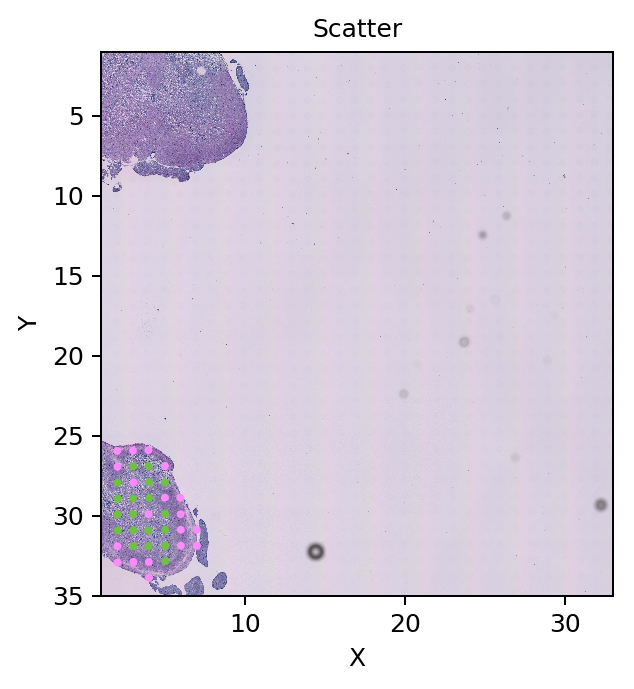

In [133]:
scatter_plot(x_points, y_points, colors=cluster, alignment=atm, image=IMG_PATH,
            output=os.path.join(CLUSTER_PATH, '{}_{}'.format("combined_model", "both_data")))